In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())

def ch(v):
    for e in chain(*v):
        if e is not None:
            yield e

j = Joint(5_000, 50_000)
       
len(limits())
    

11520

In [2]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Test:
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm.auto import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            v_c_1 = b.v_c
            assert round(b.area) == b.x, (b, i, b.flag)
            b.plan(b.t*tf)
            assert round(b.area) == b.x, (b, i, b.flag)
            assert round(b.v_c) <= b.joint.v_max, (i, b.v_c)
            
        except (Exception, AssertionError):
            errors.append( (i, tf, b))
            raise
       
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c_1=v_c_1, v_c_2=b.v_c, rc=b.recalcs, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
df.qc.value_counts(normalize=True)

  0%|          | 0/11520 [00:00<?, ?it/s]

NameError: name 'b' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Segment, SegmentList, Joint

j = Joint(500, 500_000)
joints = [j]*2

sl = SegmentList(joints)   
x = 1000
s = sl.rmove([x,x])
s = sl.rmove([-x,x])
s = sl.rmove([-x,-x])
s = sl.rmove([x,-x])
s = sl.rmove([x,x])
sl.plot()

df = sl.dataframe.set_index(['seg','ss','axis'])[['x']].unstack()
df.columns = ['x0','x1']
df = df.cumsum()
df.plot(x='x0',y='x1')


In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from math import sin, cos, sqrt
from trajectory.planner import Segment, SegmentList, Joint

from trajectory.plot import * 


j = Joint(10_000, 500_000)
joints = [j]*2

sl = SegmentList(joints)   
r = 10000
n = 100
lx  = 0
ly = 0
for i in range(1,n+1):
    a = 2*np.pi*(i/n)
    x = sin(a)*r 
    y = cos(a)*r 
    if sqrt(x**2+y**2) > 1000:
        sl.rmove((round(x-lx),round(y-ly)))
        lx = x
        ly = y


df = sl.dataframe
t = df.set_index(['seg','ss','axis'])[['x']].unstack()
t.columns = ['x0','x1']
t = t.cumsum()
t.plot.scatter(x='x0',y='x1', marker='.')

plot_trajectory(df[df.seg.between(35, 45)])

sl.plot()

In [ ]:
for d in sl.discontinuities():
    print(d[0].id, d[0].v_1, d[1].v_0)

In [ ]:
#pd.Series([ (p.v_c+c.v_c)/2-(p.v_1+c.v_0)/2 for p, c in sl.joint_pairs()]).describe()

def is_bent(p,c):
    s1 = p.v_c-p.v_1
    s2 = c.v_0-c.v_c
    
    v_m = (p.v_c+c.v_c)/2
    
    if sign(s1) != sign (s2) and abs(v_m-p.v_1) > 500:
        return True
    
for  p, c in sl.joint_pairs():
    if bent(p, c):
        print(p.id, [ round(e) for e in (p.v_c, p.v_1, c.v_0, c.v_c) ] )
        p.v_1 = c.v_0 = (p.v_c+c.v_c)/2
        
sl.plot()
    
for s in sl:
    s.plan()
    
sl.plot()    

In [ ]:
plot_trajectory(df[df.seg.between(75, 80)])

In [ ]:
# Draw the shape using simulated steps 

from itertools import zip_longest
ss = sl[0].sim()

rows = []
for s in sl:
    for phase in s.sim():
        last = [None] * len(sl.joints)
        for step in zip_longest(*[p.iter_time(4) for p in phase]):
            for i, s in enumerate(step):
                if s is not None:
                    last[i] = s
        d = {}
        for i,s in enumerate(last):
            d[f'x{i}'] = s.x

        rows.append(d)
        
df = pd.DataFrame(rows)
df = df.cumsum()
display(df.head())
df.plot(x='x0',y='x1')

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList
from trajectory.plot import *
from random import random, randint
j = Joint(5_000, 50_000)
n = 4
joints = [j]*n
signs = [1]*n

sl = SegmentList(joints)   

def iz():
    # 
    return 

def rand_move(axis):

    z = int(random() < .9) # Make 10% of the moves zero
    if random() < .1: # change direction 10% of the time
        signs[axis] = -signs[axis]

    return z * signs[axis] * randint(0,1000)
 

move_sets = [ [ rand_move(axis) for axis in range(len(joints))] for _ in range(1000) ]
        

for move_n, moves in tqdm(list(enumerate(move_sets))):
    try:
        sl.rmove(moves)
    except:
        print("Move=", move_n, move_sets[move_n])
        raise
 
ds = list(sl.discontinuities())
if len(ds):
    warn(f"Got {len(ds)} discontinuities") 
    for a, b in sl.discontinuities():
        print(a.id, abs(a.v_1-b.v_0) )

#df = sl.dataframe
#df = df[df.axis==0]
#sl.plot()

In [ ]:
df = sl.dataframe
df = df[df.axis==0]
plot_trajectory(df.iloc[100:110])

In [ ]:
from trajectory.planner import * 
    
j = Joint(5_000, 50_000)


 
l = split_moves([1234,117,5050,400,2000] ,j)

[sum(e) for e in l]

list(zip(*l))     

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Too many planning updates for sid=1.
from trajectory.planner import Segment, SegmentList, Joint

j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.smove([-538, 372, 539, 920])
sl.smove([-359, 308, 562, 838])
sl.smove([-497, 631, 409, -861])
sl.smove([-479, 298, 109, -874])
sl.smove([-203, 557, 0, 495])
sl.smove([-112, 683, 0, 0])
sl.smove([257, 130, 751, 0])

sl.plot()

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Too many planning updates for sid=1.
from trajectory.planner import *
j = Joint(5_000, 50_000)
joints = [j]*4

sl = SegmentList(joints)  

sl.smove([-2000, 1000, 300, 1700])

sl.plot()

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.isolver import *
from trajectory import Joint 
    
j = Joint(5_000, 50_000)

(x, v_0, v_1, j) = 1000, 0, 0, j

l, al, j = ipsplit(x, v_0, v_1, j, n=3)

print(l)
print(al(l))
print(mean(al(l)))
print(minv(j,al(l)), maxv(j,al(l)))
print(mean_err(al(l)))
print(can_donate(j,al(l)))
print(can_recieve(j,al(l)))

500 1000 0
1000 2000 0
2000 3000 0
300 4000 0


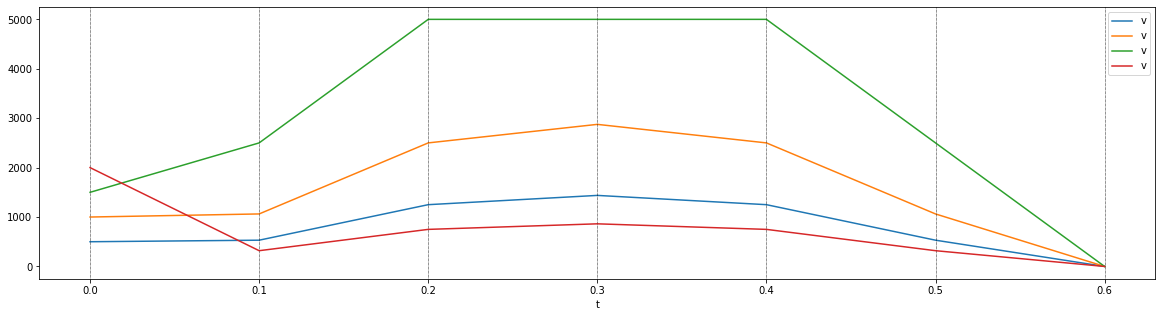

In [2]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.isolver import *
from trajectory import * 
from itertools import chain

j = Joint(5_000, 50_000)
joints = [j]*4

s = Segment(0,[500,1000,2000,300],joints,)
s.solve(bv_0=[1000,2000,3000,4000])
s.plot()

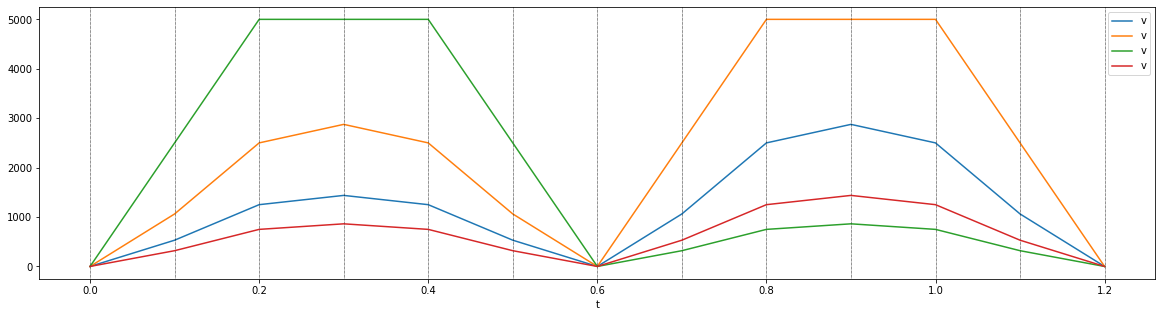

In [12]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.isolver import *
from trajectory import * 
from itertools import chain

j = Joint(5_000, 50_000)
joints = [j]*4
sl = SegmentList(joints)


sl.move([500,1000,2000,300])
sl.move([1000,2000,300, 500])

sl.plot()


In [21]:
sl[0].dataframe.columns

Index(['t', 'seg', 'axis', 'x', 'v_i', 'v_f', 'del_t'], dtype='object')

In [7]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from trajectory.isolver import *
from trajectory import Joint 
from itertools import chain



class SL(SegmentList):
    def move(self, move: List[int]):
        """Add a new segment, with joints expressing joint distance
        :type x: object
        """

        max_index = longest_index(move)
        
        # Split the longest axis to get the number of  divisions
        l, al, js = ipsplit(max(move), 0, 0, self.joints[max_index])
        n = len(l)
  
        blocks_t = []

        if len(self.segments) > 0:
            v_0s = [p.v_1 for p in self.segments[-1].blocks]
        else:
            v_0s = [0]*len(self.joints)
    
        for x, j, v_0 in zip(move, self.joints, v_0s):
        
            prior = self.segments[-1] if len(self.segments) > 0 else None
            

            l =  ipsolve(x, v_0, v_max, js,n=n)
            blocks_t.append([make_block(p,c,n, j, js) for (p, c, n) in triplets(l)])
                
        # Un-transpose the blocks sets:
        for blocks in zip(*blocks_t):
            s = Segment(len(self.segments), blocks, prior)
            self.segments.append(s)
        
j = Joint(5_000, 50_000)
joints = [j]*4
    
sl = SL(joints)
sl.move([ 200, 3500, 1000])
sl.move([ 500, 2500, 1000])
sl.move([ 200, 1500, 1000])
sl.plot()


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Too many planning updates for sid=1.
from trajectory.planner import *
j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)  

for move in zip(*splits):
    sl.rmove(move)

sl.plot()
sl

In [ ]:
l